In [22]:
# Let's import the libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import folium
import json
from ipywidgets import IntSlider, interact

import math
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
#reading the FAO data set
fertilizer_area=pd.read_csv('./data/Environment_Fertilizers_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')
crops=pd.read_csv('./data/Production_Crops_E_All_Data_(Normalized).zip',sep=',',encoding='latin-1')

In [3]:
#Determining countries most fertilizer consumer for the last year of using
fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
    .query('`Year Code` == 2016')
    .query('`Area Code` <300') #exclude the grouped countried (i.e. europe, etc)
    .sort_values('Value', ascending=False)
)

fertilizer.head(2)

,Area Code,Area,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
2030,59,Egypt,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2016,2016,kg/ha,366.87,Fc
4328,150,Netherlands,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,2016,2016,kg/ha,244.89,Fc


In [4]:
grouped_yields=(crops.query('`Element Code` == 5419') #take yield (not production, area harvested)
        .query('`Year Code` == 2016')
        .query('`Item Code` >1000') #take the grouped foods
        .pivot(index='Area',columns='Item',values='Value')
        .fillna(value=0) 
        .reset_index()
          )
grouped_yields.head(2)

Item,Area,Cereals (Rice Milled Eqv),"Cereals,Total","Citrus Fruit,Total","Coarse Grain, Total",Fruit Primary,"Pulses,Total","Roots and Tubers,Total","Treenuts,Total",Vegetables Primary
0,Afghanistan,19391.0,19816.0,83127.0,16667.0,88201.0,7406.0,119868.0,15984.0,91869.0
1,Africa,14245.0,15261.0,108260.0,13007.0,88514.0,7629.0,85875.0,5437.0,83707.0


In [5]:
def ferti_class(x, L): #associate a color to each bin of fertilizer
    if x<np.percentile(L,33):
        return 'low'
    elif np.percentile(L,33)<=x<np.percentile(L,66):
        return 'medium'
    else:
        return 'high'

In [6]:
def pre_processing_PCA(df, target, features):
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the countries
    y = df.loc[:,[target]].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    return x

def PCA_processing(df, target, features):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(pre_processing_PCA(df, target, features))
    principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
    return pca,pd.concat([principalDf, df[[target]]], axis=1)

In [9]:
pca,grouped_yield_pca = PCA_processing(grouped_yields,'Area', grouped_yields.columns[1:])
grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))

Text(0, 0.5, 'Fertilizer use')

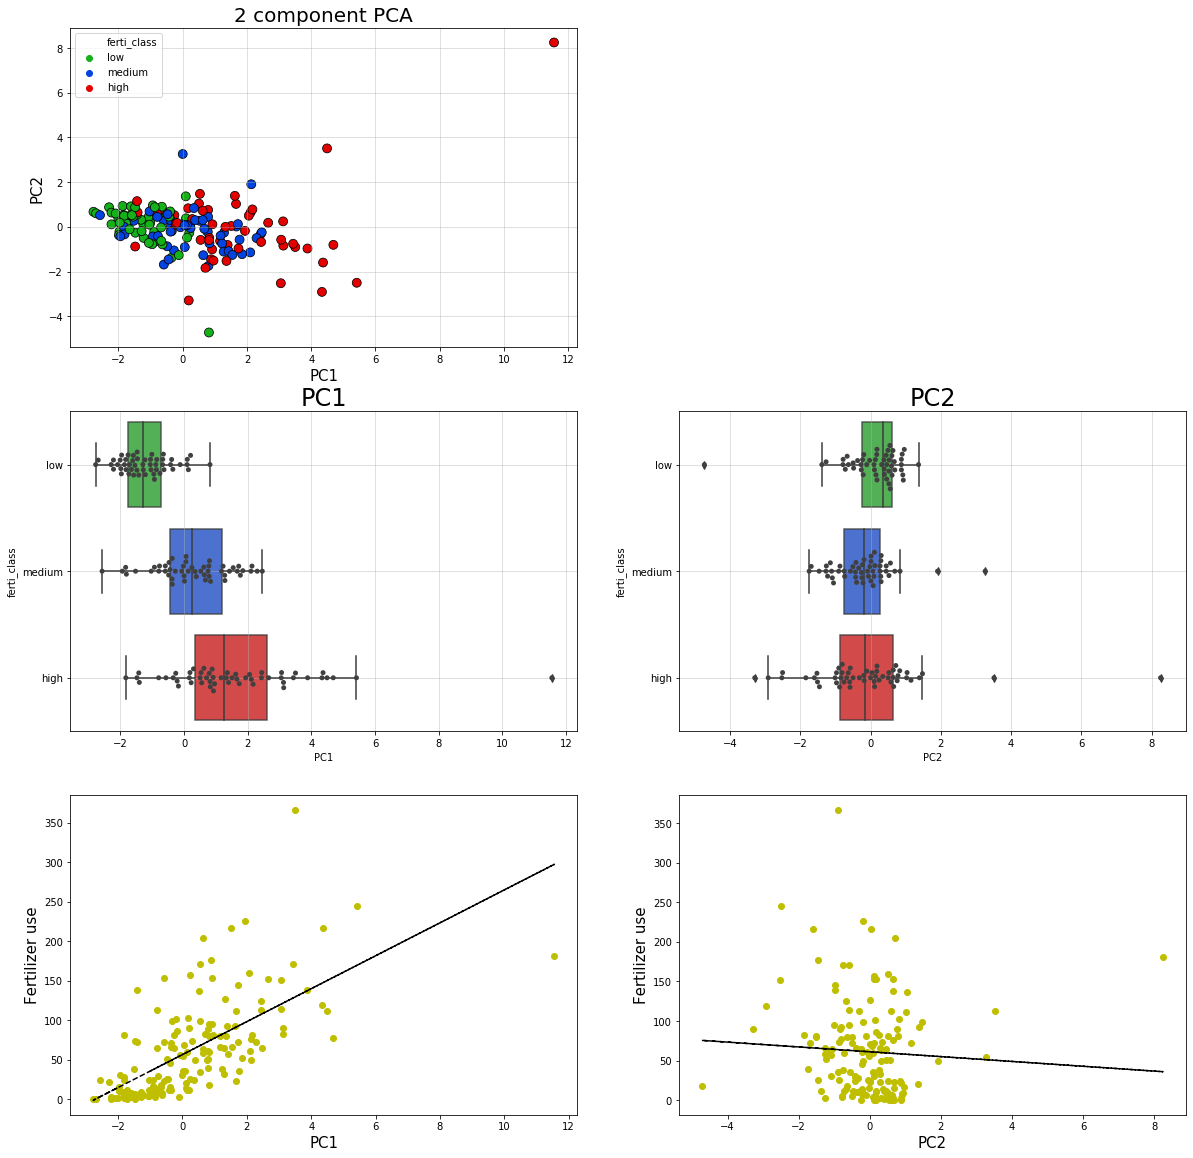

In [10]:
#Viz for 1 year 
figure = plt.figure(figsize = (20,20))
colors = ["green", "blue", "red"]

ax1 = figure.add_subplot(3,2,1)
ax1.set_xlabel('Principal Component 1', fontsize = 15)
ax1.set_ylabel('Principal Component 2', fontsize = 15)
ax1.set_title('2 component PCA', fontsize = 20)
ax1.grid(alpha=0.5)
ax1 = sns.scatterplot(x='PC1', y='PC2', hue='ferti_class', palette=sns.xkcd_palette(colors), data=grouped_yield_pca, s=80,edgecolor="black")

ax2 = figure.add_subplot(3,2,3)
ax2 = sns.boxplot(x='PC1', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax2 = sns.swarmplot(x='PC1', y='ferti_class', data=grouped_yield_pca, color=".25")
ax2.grid(alpha=0.5)
plt.title('PC1', fontsize=24);

ax3 = figure.add_subplot(3,2,4)
ax3 = sns.boxplot(x='PC2', y='ferti_class', data=grouped_yield_pca, palette=sns.xkcd_palette(colors), boxprops=dict(alpha=.8))
ax3 = sns.swarmplot(x='PC2', y='ferti_class', data=grouped_yield_pca, color=".25")
ax3.grid(alpha=0.5)
plt.title('PC2', fontsize=24);

ax4 = figure.add_subplot(3,2,5)
coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC1,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC1, poly1d_fn(grouped_yield_pca.PC1), '--k')
ax4.set_xlabel('PC1', fontsize = 15)
ax4.set_ylabel('Fertilizer use', fontsize = 15)

ax5 = figure.add_subplot(3,2,6)
coef = np.polyfit(grouped_yield_pca.PC2,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)
plt.plot(grouped_yield_pca.PC2,grouped_yield_pca.Value, 'yo',grouped_yield_pca.PC2, poly1d_fn(grouped_yield_pca.PC2), '--k')
ax5.set_xlabel('PC2', fontsize = 15)
ax5.set_ylabel('Fertilizer use', fontsize = 15)

In [39]:
coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)
poly1d_fn = np.poly1d(coef)

poly1d_fn

poly1d([20.86552218, 56.35465252])

In [51]:
years = []
PC1_low = []
PC1_medium = []
PC1_high = []
PC1 = []
ferti_low = []
ferti_medium = []
ferti_high = []
ferti = []
fertilizer_effect = []
proportion_explained = []


for year in range(2002,2017):
    years += [year]
    
    grouped_yield=crops.query('`Element Code` == 5419')\
                                .query('`Year Code` == @year')\
                                .query('`Item Code` >1000')\
                                .pivot(index='Area',columns='Item',values='Value')\
                                .fillna(value=0)\
                                .reset_index()

    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))

    PC1_low += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='low'])]
    PC1_medium += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='medium'])]
    PC1_high += [np.median(grouped_yield_pca.PC1[grouped_yield_pca.ferti_class=='high'])]
    PC1 += [np.median(grouped_yield_pca.PC1)]
    
    
    #print(len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium']),len(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high']))
    ferti_low += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='low'])]
    ferti_medium += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='medium'])]
    ferti_high += [np.median(grouped_yield_pca.Value[grouped_yield_pca.ferti_class=='high'])]
    
    ferti += [np.median(grouped_yield_pca.Value)]
    
    fertilizer_effect += [np.poly1d(np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1))[1]]
    proportion_explained += [pca.explained_variance_ratio_[0]]

Text(0, 0.5, 'fertilizer effect')

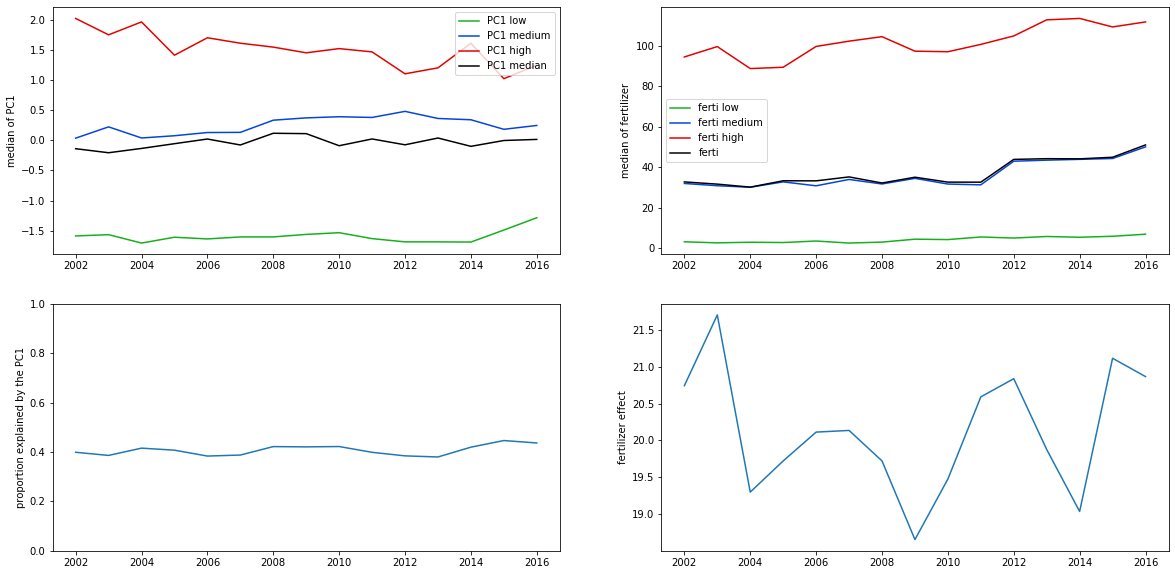

In [52]:
evolution_ferti = pd.DataFrame([years, PC1_low, PC1_medium, PC1_high, ferti_low, ferti_medium, ferti_high,ferti,PC1, proportion_explained, fertilizer_effect], ['year', 'PC1 low', 'PC1 medium', 'PC1 high','ferti low', 'ferti medium', 'ferti high','ferti','PC1 median', 'proportion explained', 'fertilizer_effect']).T

figure = plt.figure(figsize = (20,10))
ax1 = figure.add_subplot(2,2,1)
ax1.plot("year", "PC1 low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax1.plot("year", "PC1 medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax1.plot("year", "PC1 high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax1.plot("year", "PC1 median", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax1.set_ylabel('median of PC1')
ax1.legend()

ax2 = figure.add_subplot(2,2,2)
ax2.plot("year", "ferti low", data=evolution_ferti, color=sns.xkcd_palette(colors)[0])
ax2.plot("year", "ferti medium", data=evolution_ferti, color=sns.xkcd_palette(colors)[1])
ax2.plot("year", "ferti high", data=evolution_ferti, color=sns.xkcd_palette(colors)[2])
ax2.plot("year", "ferti", data=evolution_ferti, color=sns.xkcd_rgb["black"])
ax2.set_ylabel('median of fertilizer')
ax2.legend()

ax3 = figure.add_subplot(2,2,3)
ax3.plot("year", 'proportion explained', data=evolution_ferti)
ax3.set_ylabel('proportion explained by the PC1')
ax3.set_ylim([0,1])

ax4 = figure.add_subplot(2,2,4)
ax4.plot("year", 'fertilizer_effect', data=evolution_ferti)
ax4.set_ylabel('fertilizer effect')

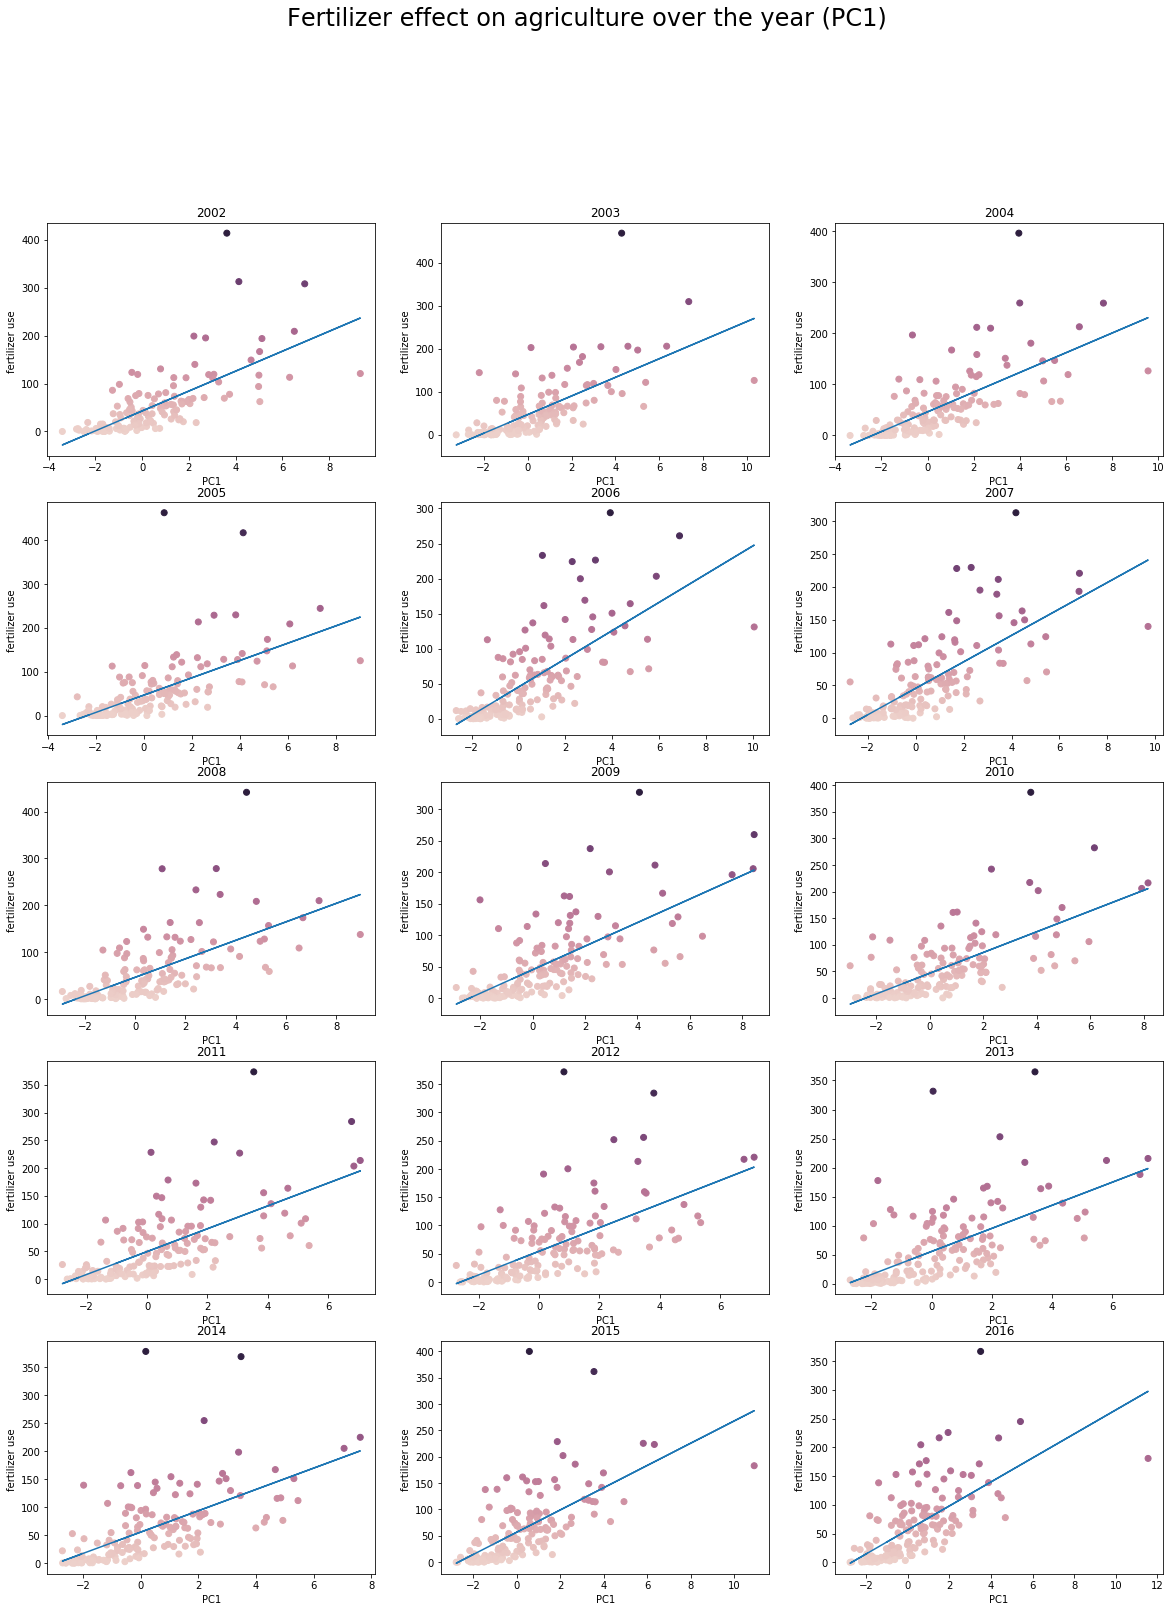

In [68]:
fig = plt.figure(figsize = (20, math.ceil(16/3)*5 ))
fig.suptitle('Fertilizer effect on agriculture over the year (PC1)', fontsize=24)

index = -1


for year in range(2002,2017):
    years += [year]
    index += 1
    
    grouped_yield=crops.query('`Element Code` == 5419')\
                                .query('`Year Code` == @year')\
                                .query('`Item Code` >1000')\
                                .pivot(index='Area',columns='Item',values='Value')\
                                .fillna(value=0)\
                                .reset_index()

    pca,grouped_yield_pca = PCA_processing(grouped_yield,'Area', grouped_yield.columns[1:])


    fertilizer=(fertilizer_area.query('`Item Code` == (3102)')
        .query('`Year Code` == @year')
        .query('`Area Code` <300')
        .sort_values('Value', ascending=False)
    )

    grouped_yield_pca=pd.merge(grouped_yield_pca,fertilizer.loc[:,['Area','Value']],left_on='Area',right_on='Area')
    grouped_yield_pca['ferti_class']=grouped_yield_pca.Value.apply(lambda x: ferti_class(x, grouped_yield_pca.Value))

    ax1 = fig.add_subplot(math.ceil(16/3),3,index+1)
    coef = np.polyfit(grouped_yield_pca.PC1,grouped_yield_pca.Value,1)
    poly1d_fn = np.poly1d(coef)
    clarity_ranking = grouped_yield_pca.Value

    cmap = sns.cubehelix_palette(as_cmap=True)
    plt.scatter(grouped_yield_pca.PC1, grouped_yield_pca.Value,c=clarity_ranking, cmap=cmap)
    plt.plot(grouped_yield_pca.PC1, poly1d_fn(grouped_yield_pca.PC1))
    plt.title('%d'%year);
    plt.xlabel("PC1")
    plt.ylabel("fertilizer use ")